# 0. LSTM.zip 업로드
#### LSTM 폴더 구조
```bash
LSTM
├── Video
│   ├── 0. normal
│   │   ├── normal1.mp4
│   │   ├── normal2.mp4
│   │   └── ...
│   ├── 1. doubt
│   │   ├── doubt1.mp4
│   │   ├── doubt2.mp4
│   │   └── ...
│   └── 2. danger
│       ├── danger1.mp4
│       ├── danger2.mp4
│       └── ...
└── Model
    └── yolo11s-pose.pt

```



# 1. 라이브러리 설치 및 로드

In [1]:
!pip uninstall -y tensorflow keras -qqq
!pip uninstall -y tf-keras tensorflow-text tensorstore ml-dtypes dopamine-rl orbax-checkpoint flax -qqq
!pip install tensorflow==2.15.0 keras==2.15.0 -qqq
!pip install ultralytics -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/

In [2]:
import os
import re
import cv2
import csv
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 2. 함수 정의

In [3]:
# 영상 증강
def get_next_filename(directory, base_name, extension='.mp4'):
    os.makedirs(directory, exist_ok=True)
    existing_files = [f for f in os.listdir(directory) if f.startswith(base_name) and f.endswith(extension)]
    numbers = [int(f[len(base_name):-len(extension)]) for f in existing_files if f[len(base_name):-len(extension)].isdigit()]
    next_number = max(numbers, default=0) + 1
    return os.path.join(directory, f"{base_name}{next_number}{extension}")

def augment_video(video_path, save_dir, speed=1.0, rotate=0, flip_horizontal=False, flip_vertical=False, resize_scale=1.0, translate_x=0, translate_y=0):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"비디오 파일을 열 수 없습니다: {video_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * resize_scale)
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * resize_scale)
    fps = cap.get(cv2.CAP_PROP_FPS) * speed

    base_name = os.path.basename(video_path).split('.')[0]
    save_path = get_next_filename(save_dir, base_name)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(save_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize
        frame = cv2.resize(frame, (frame_width, frame_height))

        # Rotate
        if rotate != 0:
            center = (frame_width // 2, frame_height // 2)
            rot_matrix = cv2.getRotationMatrix2D(center, rotate, 1.0)
            frame = cv2.warpAffine(frame, rot_matrix, (frame_width, frame_height))

        # Flip
        if flip_horizontal:
            frame = cv2.flip(frame, 1)
        if flip_vertical:
            frame = cv2.flip(frame, 0)

        # Translate
        if translate_x != 0 or translate_y != 0:
            trans_matrix = np.float32([[1, 0, translate_x], [0, 1, translate_y]])
            frame = cv2.warpAffine(frame, trans_matrix, (frame_width, frame_height))

        out.write(frame)

    cap.release()
    out.release()
    print(f"비디오 증강 완료. 저장 경로: {save_path}")

def process_all_videos(root_dir, save_root_dir, speed=1.0, rotate=0, flip_horizontal=False, flip_vertical=False, resize_scale=1.0, translate_x=0, translate_y=0):
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.mp4'):
                video_path = os.path.join(subdir, file)
                relative_path = os.path.relpath(subdir, root_dir)
                save_dir = os.path.join(save_root_dir, relative_path)
                augment_video(video_path, save_dir, speed, rotate, flip_horizontal, flip_vertical, resize_scale, translate_x, translate_y)

In [9]:
def capture_yolo_pose_frames_with_tracking(video_dir, output_dir, model_path, fps_capture=3):
    model = YOLO(model_path)

    # 하위 폴더 탐색
    for root, dirs, files in os.walk(video_dir):
        for video_file in files:
            if not video_file.endswith(('.mp4', '.avi', '.mov')):
                continue

            # 클래스 ID 추출 (폴더명 맨 앞 숫자)
            relative_path = os.path.relpath(root, video_dir)
            folder_name = os.path.basename(root)
            class_id = int(folder_name.split('.')[0]) if '.' in folder_name else 0

            video_path = os.path.join(root, video_file)
            video_name = os.path.splitext(video_file)[0]

            # 루트 디렉토리 구조를 유지하도록 경로 설정
            output_folder_path = os.path.join(output_dir, relative_path, video_name)
            image_dir = os.path.join(output_folder_path, 'images')
            label_dir = os.path.join(output_folder_path, 'labels')
            os.makedirs(image_dir, exist_ok=True)
            os.makedirs(label_dir, exist_ok=True)

            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"비디오 파일을 열 수 없습니다: {video_file}")
                continue

            video_fps = cap.get(cv2.CAP_PROP_FPS)
            frame_interval = int(video_fps / fps_capture)

            frame_count = 0
            saved_count = 1
            tracker_initialized = False

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_count % frame_interval == 0:
                    if not tracker_initialized:
                        results = model.track(frame, persist=False, verbose=False)
                        tracker_initialized = True
                    else:
                        results = model.track(frame, persist=True, verbose=False)

                    annotated_frame = results[0].plot()
                    frame_filename = os.path.join(image_dir, f"{video_name}_{saved_count}.png")
                    cv2.imwrite(frame_filename, annotated_frame)

                    if results[0].keypoints and results[0].boxes:  # Ensure both keypoints and boxes are available
                        keypoints = results[0].keypoints.xy.cpu().numpy()
                        boxes = results[0].boxes.xywh.cpu().numpy()  # Bounding boxes in [x_center, y_center, width, height]
                        ids = results[0].boxes.id.cpu().numpy() if results[0].boxes.id is not None else range(len(keypoints))

                        for person_id, person_keypoints, box in zip(ids, keypoints, boxes):
                            box_x, box_y, box_w, box_h = box
                            relative_keypoints = []

                            # 골반 중심 좌표 계산
                            hip_center_x = (person_keypoints[11, 0] + person_keypoints[12, 0]) / 2
                            hip_center_y = (person_keypoints[11, 1] + person_keypoints[12, 1]) / 2

                            # 어깨(5,6)와 힙(11,12) 사이의 거리 평균을 크기 정규화 기준으로 사용
                            shoulder_width = np.linalg.norm(person_keypoints[5] - person_keypoints[6])
                            hip_width = np.linalg.norm(person_keypoints[11] - person_keypoints[12])
                            scale = (shoulder_width + hip_width) / 2  # 평균값 사용

                            # scale이 0이면 정규화 방지
                            if scale == 0:
                                scale = 1

                            relative_keypoints = []
                            for i in range(17):
                                kp_x = (person_keypoints[i, 0] - hip_center_x) / scale  # 골반 기준 x 정규화
                                kp_y = (person_keypoints[i, 1] - hip_center_y) / scale  # 골반 기준 y 정규화
                                relative_keypoints.extend([kp_x, kp_y])

                            relative_keypoints.append(class_id)

                            person_label_dir = os.path.join(label_dir, f"id_{int(person_id)}")
                            os.makedirs(person_label_dir, exist_ok=True)

                            csv_filename = os.path.join(person_label_dir, f"{video_name}_{saved_count}.csv")
                            with open(csv_filename, mode='w', newline='') as file:
                                writer = csv.writer(file)
                                headers = [f'kp{i}_x' if j % 2 == 0 else f'kp{i}_y' for i in range(17) for j in range(2)] + ['action_class']
                                writer.writerow(headers)
                                writer.writerow(relative_keypoints)

                    saved_count += 1

                frame_count += 1

            cap.release()
            print(f"{video_file}의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.")

In [5]:
# 정렬을 위한 자연 정렬 키 함수
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# 폴더 내 CSV 파일 병합
def LSTM_Capture_Merge(folder_path, sequence):

    csv_files = []

    for root, _, files in sorted(os.walk(folder_path), key=lambda x: natural_sort_key(x[0])):
        # "id_1" 폴더만 처리
        if os.path.basename(root) != "id_1":
            continue

        sorted_files = sorted([file for file in files if file.endswith('.csv')], key=natural_sort_key)
        file_count = len(sorted_files)

        if file_count == 0:
            continue  # CSV 파일이 없는 폴더는 건너뜀

        # sequence 배수에 맞도록 최대한 많은 파일 사용
        remainder = file_count % sequence
        if remainder != 0:
            excluded_files = sorted_files[-remainder:]  # 마지막에서 remainder 개만큼 제외
            sorted_files = sorted_files[:-remainder]  # 배수에 맞게 남김
            print(f"[제외] {root}: {len(excluded_files)}개 파일을 사용하지 않음 (배수 맞춤)")

        if len(sorted_files) == 0:
            continue  # 남은 파일이 없으면 건너뜀

        for file in sorted_files:
            csv_path = os.path.join(root, file)
            csv_files.append(csv_path)

    if not csv_files:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()

    # CSV 파일 병합 (float_precision 추가)
    dataframes = [pd.read_csv(file, float_precision='round_trip') for file in csv_files]
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
    return combined_df

# 데이터 시퀀스별로 변환
def reshape_to_sequences(data, labels, seq_length):
    sequences = []
    sequence_labels = []
    for i in range(0, len(data) - seq_length + 1, seq_length):
        sequences.append(data[i:i + seq_length])
        sequence_labels.append(labels[i + seq_length - 1])
    return np.array(sequences), np.array(sequence_labels)

# 클래스 균등하게 정리
def balance_classes(df, class_column, target_samples):

    # 그룹화하여 각 클래스에서 샘플링
    balanced_df = df.groupby(class_column).apply(
        lambda x: x.sample(n=target_samples, random_state=42) if len(x) >= target_samples else x
    )

    # 인덱스 초기화
    balanced_df = balanced_df.reset_index(drop=True)
    return balanced_df

# 3. 데이터 준비

In [6]:
# 파일 압축 해제
with zipfile.ZipFile('/content/LSTM.zip', 'r') as my_zip:
    my_zip.extractall('LSTM')
    print("압축 해제")

압축 해제


# 4. 비디오 증강

In [23]:
# 경로 설정
root_video_dir = '/content/LSTM/Video'
save_root_dir = '/content/LSTM/Video_Aug'

#### 증강 실행

In [24]:
process_all_videos(root_video_dir, save_root_dir, speed = 1.0, rotate = 5,
                    flip_horizontal = False, resize_scale = 1.0)

비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal191.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal81.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal111.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal91.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal192.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal131.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal31.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/normal241.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal51.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal201.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal101.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal22.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal41.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal181.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal141.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. 

In [25]:
process_all_videos(root_video_dir, save_root_dir, speed = 1.0, rotate = -5,
                    flip_horizontal = False, resize_scale = 1.0)

비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal193.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal82.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal112.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal92.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal194.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal132.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal32.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/normal242.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal52.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal202.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal102.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal23.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal42.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal182.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. nomal/nomal142.mp4
비디오 증강 완료. 저장 경로: /content/LSTM/Video_Aug/0. 

# 5. 프레임 및 키포인트 추출

In [7]:
# 경로 설정
output_dir = '/content/LSTM/Data/LSTM_Capture'
model_path = '/content/LSTM/Model/yolo11s-pose.pt'

# 초당 프레임 수 설정
fps_capture=9

In [10]:
# Video 폴더 추출
capture_yolo_pose_frames_with_tracking('/content/LSTM/Video', output_dir, model_path, fps_capture)

nomal19.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal8.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal11.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal9.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal1.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal13.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal3.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
normal24.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal5.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal20.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal10.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal2.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal4.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal18.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal14.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal17.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal7.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
normal23.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal15.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
normal26.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
normal22.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal16.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
normal25.mp4의 

In [26]:
# Video_Aug 폴더 추출
capture_yolo_pose_frames_with_tracking('/content/LSTM/Video_Aug', output_dir, model_path, fps_capture)

normal211.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal142.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal22.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal61.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal41.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal112.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal132.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal81.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal23.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal62.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
normal262.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal71.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal32.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal101.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal182.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal121.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal122.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
normal221.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal181.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal172.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal202.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저장 완료.
nomal31.mp4의 YOLO-pose 프레임 및 키포인트 데이터 저

# 6. 모델 학습

In [27]:
# 데이터 불러오기 및 병합
folder_path = '/content/LSTM/Data'  # 데이터 폴더 경로
df = LSTM_Capture_Merge(folder_path + '/LSTM_Capture', sequence=10) # LSTM_Capture 폴더 병합

[제외] /content/LSTM/Data/LSTM_Capture/0. nomal/nomal193/labels/id_1: 9개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/0. nomal/normal25/labels/id_1: 9개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/0. nomal/normal251/labels/id_1: 9개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/0. nomal/normal252/labels/id_1: 9개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/0. nomal/normal261/labels/id_1: 7개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/0. nomal/normal262/labels/id_1: 8개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/1. doubt/doubt31/labels/id_1: 9개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/1. doubt/doubt32/labels/id_1: 9개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/1. doubt/doubt52/labels/id_1: 9개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/1. doubt/doubt201/labels/id_1: 9개 파일을 사용하지 않음 (배수 맞춤)
[제외] /content/LSTM/Data/LSTM_Capture/1. doubt/doubt202/labels/id_1: 8개 파일을 사용하지 않음 (배수 맞춤

In [28]:
# 데이터프레임 확인
print(df['action_class'].value_counts())
df

action_class
0    3840
2    3820
1    3320
Name: count, dtype: int64


,kp0_x,kp0_y,kp1_x,kp1_y,kp2_x,kp2_y,kp3_x,kp3_y,kp4_x,kp4_y,...,kp12_y,kp13_x,kp13_y,kp14_x,kp14_y,kp15_x,kp15_y,kp16_x,kp16_y,action_class
0,-0.140564,-2.199924,0.005514,-2.331716,-0.275942,-2.329942,0.269833,-2.287422,-0.430778,-2.286694,...,-0.010311,0.437766,1.007596,-0.194177,0.929001,0.351435,1.723927,-0.104984,1.627277,0
1,-0.164568,-2.161265,-0.012369,-2.298413,-0.302555,-2.297894,0.260296,-2.261634,-0.461913,-2.262401,...,-0.003787,0.432306,0.953878,-0.188814,0.894685,0.325415,1.634643,-0.096559,1.542423,0
2,-0.188472,-2.173982,-0.034437,-2.315110,-0.323655,-2.309010,0.243230,-2.280857,-0.478212,-2.274975,...,-0.001936,0.405287,0.931242,-0.251648,0.881581,0.326903,1.677078,-0.097489,1.579654,0
3,-0.162862,-2.159971,-0.008469,-2.293472,-0.300509,-2.293895,0.280179,-2.276454,-0.455705,-2.282446,...,-0.004860,0.455874,0.967579,-0.197519,0.920980,0.375316,1.647242,-0.076665,1.589530,0
4,-0.140220,-2.259135,0.012229,-2.396868,-0.282945,-2.400139,0.293350,-2.346896,-0.449886,-2.364821,...,-0.018836,0.481251,0.993730,-0.203823,0.917375,0.393966,1.645650,-0.056849,1.615203,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,0.048432,-3.720598,-6.537872,-6.836615,-0.175609,-3.837796,-6.537872,-6.836615,-0.666317,-3.598788,...,0.190695,0.660651,1.087956,-0.195874,1.808381,0.572700,2.424151,-0.361493,3.264985,2
10976,0.023418,-2.849139,-5.050824,-5.171612,-0.182293,-2.897739,-5.050824,-5.171612,-0.540475,-2.674140,...,0.167542,0.518340,0.842923,-0.129371,1.457484,0.379366,1.912372,-0.230214,2.571649,2
10977,0.085108,-2.582522,-4.535857,-4.712464,-0.075771,-2.631036,-4.535857,-4.712464,-0.443097,-2.468938,...,0.130777,0.528766,0.899608,-0.183969,1.355012,0.339709,1.861922,-0.201923,2.347787,2
10978,0.036279,-3.084351,0.032461,-3.278569,-0.168856,-3.161139,-5.517741,-5.691810,-0.561654,-2.958439,...,0.168156,0.485719,0.978362,-0.179580,1.559749,0.350644,2.206500,-0.224398,2.751947,2


In [29]:
# X, y 분리
X = df.iloc[:, :-1].values # 키포인트
y = df.iloc[:, -1].values # 클래스

In [30]:
# 레이블 원-핫 인코딩
y = to_categorical(y)

In [31]:
# 데이터 시퀀스 길이 지정
seq_length = 10  # 시퀀스 길이

# 데이터를 시퀀스 형태로 변환
X_seq, y_seq = reshape_to_sequences(X, y, seq_length)

# shape 확인
X.shape, X_seq.shape, y.shape, y_seq.shape

((10980, 34), (1098, 10, 34), (10980, 3), (1098, 3))

In [32]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [33]:
# LSTM 모델 정의
model = Sequential([
    LSTM(128, input_shape=(seq_length, X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
    ])

In [34]:
 # 모델 컴파일 및 학습
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
es = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 15, mode = 'auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=128, callbacks=[es]).history

Epoch 1/300
7/7 [==============================] - 5s 181ms/step - loss: 1.0673 - accuracy: 0.4271 - val_loss: 0.9706 - val_accuracy: 0.6136
Epoch 2/300
7/7 [==============================] - 0s 48ms/step - loss: 0.9337 - accuracy: 0.6401 - val_loss: 0.8703 - val_accuracy: 0.6591
Epoch 3/300
7/7 [==============================] - 0s 49ms/step - loss: 0.8039 - accuracy: 0.7027 - val_loss: 0.7777 - val_accuracy: 0.6955
Epoch 4/300
7/7 [==============================] - 0s 41ms/step - loss: 0.6567 - accuracy: 0.7779 - val_loss: 0.7057 - val_accuracy: 0.7045
Epoch 5/300
7/7 [==============================] - 0s 45ms/step - loss: 0.5602 - accuracy: 0.7813 - val_loss: 0.6264 - val_accuracy: 0.7591
Epoch 6/300
7/7 [==============================] - 0s 41ms/step - loss: 0.4521 - accuracy: 0.8360 - val_loss: 0.5277 - val_accuracy: 0.7909
Epoch 7/300
7/7 [==============================] - 0s 41ms/step - loss: 0.3481 - accuracy: 0.8827 - val_loss: 0.4637 - val_accuracy: 0.8000
Epoch 8/300
7/7 [==

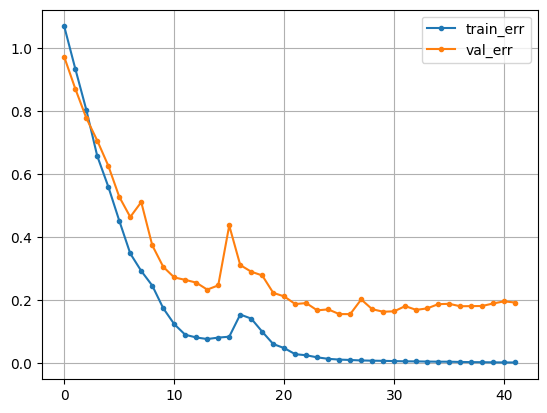

In [35]:
plt.plot(history['loss'], label = 'train_err', marker = '.')
plt.plot(history['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [36]:
# 모델 저장
output_model = '/content/LSTM/Model/LSTM.h5'
model.save(output_model)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
# 학습된 모델 평가
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"검증 데이터 정확도: {accuracy * 100:.2f}%")

검증 데이터 정확도: 96.36%


# 7. 폴더 삭제

In [ ]:
shutil.rmtree("/content/LSTM/Video_Aug")

In [ ]:
shutil.rmtree("/content/LSTM/Data")